#Proyecto 2 - Modelos Secuenciales (LSTM vs. Transformer)
###Módulos utilizados

In [8]:
import requests
import tarfile
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import time

###Descargar el tar.gz

In [2]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
tar_path = "/content/aclImdb_v1.tar.gz"
print("Descargando Dataset IMDB...")

try:
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                      "AppleWebKit/537.36 (KHTML, like Gecko) "
                      "Chrome/91.0.4472.124 Safari/537.36"
    }
    response = requests.get(url, headers=headers, stream=True)
    response.raise_for_status()

    with open(tar_path, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)

    print("Descarga Completa:", tar_path)

except requests.exceptions.RequestException as e:
    print(f"Error al descargar el archivo: {e}")
    print("Intentar con wget...")
    !wget -O /content/aclImdb_v1.tar.gz https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

Descargando Dataset IMDB...
Descarga Completa: /content/aclImdb_v1.tar.gz


### Descomprimir el archivo

In [3]:
with tarfile.open(tar_path, "r:gz") as tar:
    tar.extractall(path="/content/")
print("Dataset extraído en /content/aclImdb")

/tmp/ipython-input-4057152536.py:2: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path="/content/")


Dataset extraído en /content/aclImdb


### carga de la entrada (los textos) y el label correpondiente



In [4]:
def load_reviews_from_dir(directory, label):
    texts = []
    for fname in os.listdir(directory):
        path = os.path.join(directory, fname)
        with open(path, encoding="utf-8") as f:
            texts.append(f.read())
    return pd.DataFrame({"review": texts, "label": label})

base_path = "/content/aclImdb"

# Datos de entrenamiento en crudo Entrenamiento
train_pos = load_reviews_from_dir(os.path.join(base_path, "train/pos"), 1)
train_neg = load_reviews_from_dir(os.path.join(base_path, "train/neg"), 0)

# Datos de Test en crudo
test_pos  = load_reviews_from_dir(os.path.join(base_path, "test/pos"), 1)
test_neg  = load_reviews_from_dir(os.path.join(base_path, "test/neg"), 0)

# Concatenar
train_df = pd.concat([train_pos, train_neg], ignore_index=True)
test_df  = pd.concat([test_pos, test_neg], ignore_index=True)

train_df.head(10)
train_df.tail(10)

,review,label
24990,Who did the research for this film? It's set i...,0
24991,Lorne Michaels once again proves that he has a...,0
24992,"Boring, badly written Italian exploitation fli...",0
24993,So so special effects get in the way of recapt...,0
24994,This film is a massive Yawn proving that Ameri...,0
24995,It's just breathtaking in it's awfulness-- you...,0
24996,I may not be the one to review this movie beca...,0
24997,"Unlike ""The Adventures of Buckaroo Banzai"", or...",0
24998,"I'm a nice guy, and I like to think of myself ...",0
24999,"In my Lit. class we've just finished the book,...",0


### Tokenización y creación de vocabulario

In [5]:
# Parámetros
max_words = 20000   # vocabulario limitado a las 20k palabras más frecuentes
max_len   = 200     # longitud máxima de las secuencias (trunc/pad)

# Crear y ajustar tokenizer
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df["review"])

# Convertir textos a secuencias de enteros
x_train = tokenizer.texts_to_sequences(train_df["review"])
x_test  = tokenizer.texts_to_sequences(test_df["review"])

# Padding / truncation para tener longitudes iguales
x_train = pad_sequences(x_train, maxlen=max_len, padding="post", truncating="post")
x_test  = pad_sequences(x_test,  maxlen=max_len, padding="post", truncating="post")

# target
y_train = train_df["label"].values
y_test  = test_df["label"].values

print("Shape de entrenamiento:", x_train.shape, y_train.shape)
print("Ejemplo de secuencia:", x_train[0][:20])

Shape de entrenamiento: (25000, 200) (25000,)
Ejemplo de secuencia: [   33     1  1721     7     2    63     5     4  1599 19500    81  5976
   258 15493  6793   715     7  8423    32  8424]


### Modelo LSTM

a.	Embedding layer

b.	LSTM

c.	Capa densa final

In [6]:
#Callback de EarlyStopping
early_stop = EarlyStopping(
    monitor = 'val_loss', # monitoreamos la pérdida en al validación
    patience = 3,         # establecemos cuantas épocas van a pasar sin mejorar el modelo antes de parar
    restore_best_weights = True # retornamos los mejores pesos
)


In [ ]:
#model = Sequential([
#    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
#    LSTM(128, dropout=0.3, recurrent_dropout=0.3),  # una sola capa
#    Dropout(0.5),                                   # extra fuerte
#    Dense(64, activation='relu'),
#    Dropout(0.5),
#    Dense(1, activation='sigmoid')
#])


In [9]:
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3),
    LSTM(64, dropout=0.3),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])




model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

# --- Medir tiempo de entrenamiento ---
start_time = time.time()

history = model.fit(x_train, y_train, validation_split=0.2, epochs=10, batch_size=64, callbacks=[early_stop])

training_time_lstm = time.time() - start_time

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 314s 979ms/step - accuracy: 0.6251 - loss: 0.6651 - val_accuracy: 0.1444 - val_loss: 1.1084
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 310s 988ms/step - accuracy: 0.6608 - loss: 0.6292 - val_accuracy: 0.0000e+00 - val_loss: 0.8860
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 323s 994ms/step - accuracy: 0.6391 - loss: 0.6557 - val_accuracy: 0.0726 - val_loss: 0.9605
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 310s 992ms/step - accuracy: 0.6764 - loss: 0.6067 - val_accuracy: 0.1986 - val_loss: 1.2815
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 313s 1s/step - accuracy: 0.7363 - loss: 0.5186 - val_accuracy: 2.0000e-04 - val_loss: 0.8237
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 307s 980ms/step - accuracy: 0.6552 - loss: 0.5861 - val_accuracy: 0.4572 - val_loss: 0.8336
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 315s 1s/step - accuracy: 0.7923 - loss: 0.4720 - val_accuracy: 0.7460 - val_loss: 0.6640
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 314s 1s/step - accuracy: 0.8737 - 

### Validar el modelo LSTM

In [10]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"\nAccuracy en test: {test_acc:.4f}")


782/782 - 89s - 114ms/step - accuracy: 0.7949 - loss: 0.5006

Accuracy en test: 0.7949


### Gráfico del historial del accuracy - LSTM

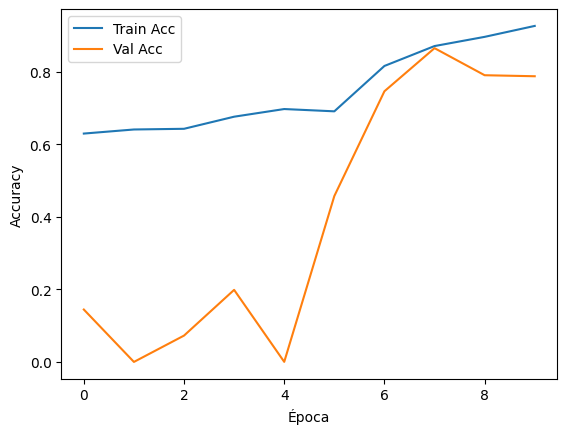

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],     label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



### Gráfico del historial del loss - LSTM



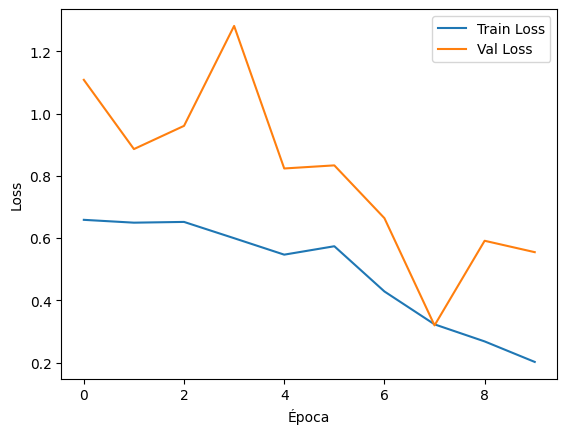

In [14]:

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Matriz de confusión - LSTM

782/782 ━━━━━━━━━━━━━━━━━━━━ 92s 117ms/step
(25000, 1)


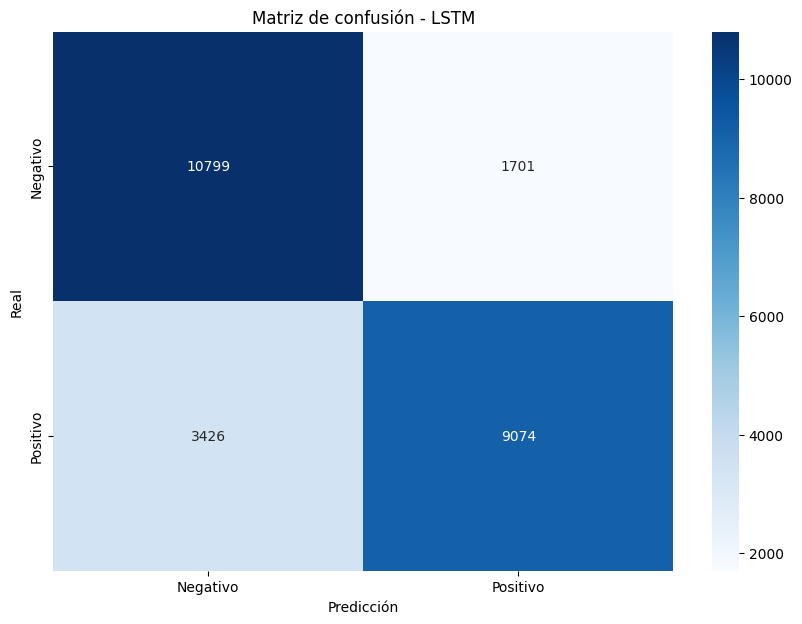

In [15]:
# Obtener probabilidades
y_pred_prob = model.predict(x_test)
print(y_pred_prob.shape)
# Convertir a etiquetas 0/1 usando threshold 0.5
y_pred = (y_pred_prob >= 0.5).astype(int).flatten()

cm = confusion_matrix(y_test, y_pred)
class_names = ["Negativo", "Positivo"]

# Visualizar la Matriz
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión - LSTM")
plt.show()

In [17]:
from sklearn.metrics import f1_score
import pandas as pd

# F1-score promedio (macro)
f1_lstm = f1_score(y_test, y_pred, average='macro')

# Número total de parámetros entrenables
params_lstm = model.count_params()

# Número de épocas realmente entrenadas
epochs_used_lstm = len(history.history['loss'])


### Classification report - LSTM

In [18]:

report = classification_report(y_test, y_pred, target_names=["Negativo", "Positivo"])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

    Negativo       0.76      0.86      0.81     12500
    Positivo       0.84      0.73      0.78     12500

    accuracy                           0.79     25000
   macro avg       0.80      0.79      0.79     25000
weighted avg       0.80      0.79      0.79     25000



### versión de Transformer

In [21]:
def transformer_block(inputs, embed_dim, num_heads, ff_dim, rate=0.1):
    attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
    attention = Dropout(rate)(attention)
    out1 = layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    ffn = Sequential([
        Dense(ff_dim, activation="relu"),
        Dense(embed_dim),
    ])
    ffn_output = ffn(out1)
    ffn_output = Dropout(rate)(ffn_output)
    out2 = layers.LayerNormalization(epsilon=1e-6)(out1 + ffn_output)
    return out2

In [22]:
vocab_size = 20000
embed_dim = 64
num_heads = 4
ff_dim = 64
max_len = 200

# Inputs
inputs = layers.Input(shape=(max_len,))

# Embedding + positional encoding simple
embedding_layer = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)(inputs)

x = transformer_block(embedding_layer, embed_dim=64, num_heads=num_heads, ff_dim=128)
x = transformer_block(x, embed_dim=64, num_heads=num_heads, ff_dim=128)

x = layers.GlobalAveragePooling1D()(x)
x = Dropout(0.4)(x)
x = layers.Dense(64, activation="relu")(x)
x = Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

# Multi-head self-attention
#attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(embedding_layer, embedding_layer)
#attention_output = layers.Add()([embedding_layer, attention_output])  # residual
#attention_output = layers.LayerNormalization()(attention_output)

# Feedforward network
#ff_output = layers.Dense(ff_dim, activation="relu")(attention_output)
#ff_output = layers.Dense(embed_dim)(ff_output)
#ff_output = layers.Add()([attention_output, ff_output])  # residual
#ff_output = layers.LayerNormalization()(ff_output)

# Global pooling + clasificador final
#x = layers.GlobalAveragePooling1D()(ff_output)
#x = layers.Dropout(0.2)(x)
#outputs = layers.Dense(1, activation="sigmoid")(x)

# Modelo
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 200, 64)   │  1,280,000 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 64)   │     66,368 │ embedding_3[0][0… │
│ (MultiHeadAttentio… │                   │            │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 200, 64)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 200, 64)   │          0 │ embedding_3[0][0… │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 200, 64)   │     16,576 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 200, 64)   │          0 │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 200, 64)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 200, 64)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 200, 64)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 200, 64)   │     16,576 │ layer_normalizat… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 200, 64)   │          0 │ sequential_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 200, 64)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                 

 Total params: 1,450,625 (5.53 MB)

 Trainable params: 1,450,625 (5.53 MB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento Transformer

In [23]:
start_time = time.time()

history_t = model.fit(
    x_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=64,
    callbacks=[early_stop]
)

training_time_transformer = time.time() - start_time

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 563s 2s/step - accuracy: 0.6742 - loss: 0.5971 - val_accuracy: 0.8266 - val_loss: 0.3893
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 569s 2s/step - accuracy: 0.9233 - loss: 0.2085 - val_accuracy: 0.8596 - val_loss: 0.4324
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 527s 2s/step - accuracy: 0.9661 - loss: 0.1033 - val_accuracy: 0.8122 - val_loss: 0.5647
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 525s 2s/step - accuracy: 0.9815 - loss: 0.0612 - val_accuracy: 0.8260 - val_loss: 0.7159


### Evaluación Transformer

In [24]:
test_loss_t, test_acc_t = model.evaluate(x_test, y_test, verbose=2)
print(f"\nAccuracy en test: {test_acc_t:.4f}")


782/782 - 202s - 258ms/step - accuracy: 0.8569 - loss: 0.3365

Accuracy en test: 0.8569


### Gráfico del historial del accuracy - Transformer

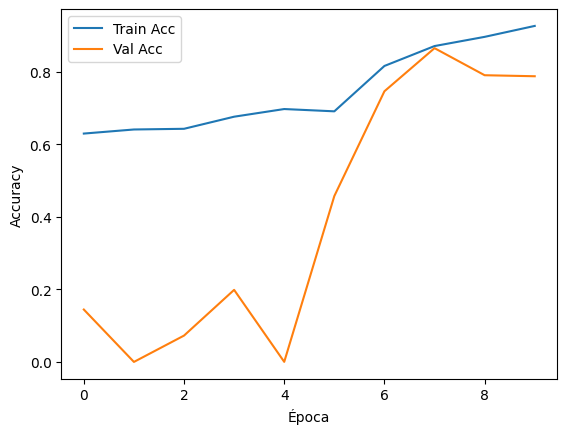

In [25]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],     label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


### Gráfico del historial del loss - Transformer

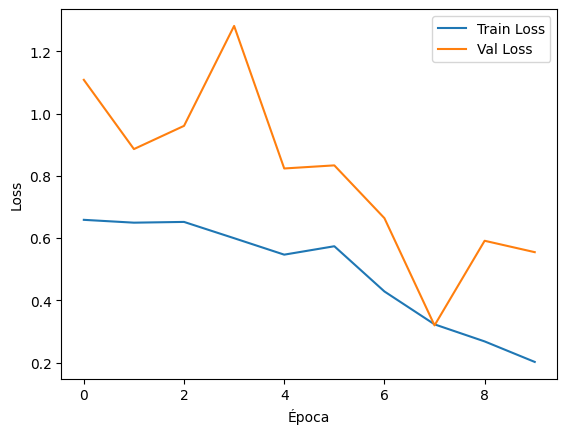

In [26]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Matriz de confusión - Transformer

782/782 ━━━━━━━━━━━━━━━━━━━━ 200s 255ms/step


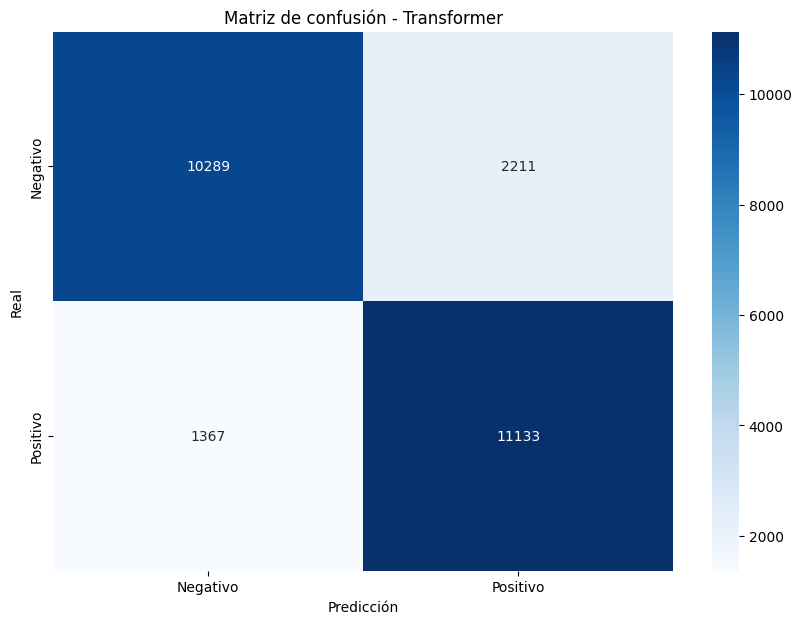

In [27]:
# Obtener probabilidades
y_pred_prob = model.predict(x_test)

# Convertir a etiquetas 0/1 usando threshold 0.5
y_pred = (y_pred_prob >= 0.5).astype(int).flatten()

cm = confusion_matrix(y_test, y_pred)
class_names = ["Negativo", "Positivo"]

# Visualizar la Matriz
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión - Transformer")
plt.show()

### Classification Report

In [28]:
report = classification_report(y_test, y_pred, target_names=["Negativo", "Positivo"])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

    Negativo       0.88      0.82      0.85     12500
    Positivo       0.83      0.89      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



In [30]:

# F1-score promedio (macro)
f1_transformer = f1_score(y_test, y_pred, average='macro')

# Número total de parámetros entrenables
params_transformer = model.count_params()

# Número de épocas realmente entrenadas
epochs_used_transformer = len(history_t.history['loss'])




# Crear DataFrame con una sola fila resumen
summary = pd.DataFrame([{
    "modeolo": "LSTM",
    "accuracy": test_acc,
    "F1_macro": f1_lstm,
    "loss": test_loss,
    "epochs": epochs_used_lstm,
    "params": params_lstm,
    "training_time_sec": training_time_lstm
},{
    "modeolo": "Transformer",
    "accuracy": test_acc_t,
    "F1_macro": f1_transformer,
    "loss": test_loss_t,
    "epochs": epochs_used_transformer,
    "params": params_transformer,
    "training_time_sec": training_time_transformer
}])

# Guardar en CSV
summary.to_csv("02_LSTM_vs_Transformer.csv", index=False)

print("\n Archivo 'summary.csv' creado con las métricas principales.")



 Archivo 'summary.csv' creado con las métricas principales.
